In [ ]:
!pip install -q --no-cache-dir transformers==4.51.3 datasets==3.5.0 peft==0.15.2 evaluate==0.4.3 sacrebleu==2.5.1
!pip install -q --no-cache-dir accelerate==1.6.0 -U
!pip install -q --no-cache-dir tensorboard==2.18.0 matplotlib==3.10.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 233.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 192.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 360.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.1/411.1 kB 338.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 274.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 145.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 330.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.55.4
    Uninstalling transformers-4.55.4:
      Successfully uninstalled transformers-4.55.4
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalli

# Imports

In [ ]:
import os
import numpy as np
import torch
from datasets import load_dataset

from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
    EarlyStoppingCallback
)
from peft import (
    LoraConfig,
    get_peft_model,
    TaskType
)
import evaluate
import matplotlib.pyplot as plt
import pandas as pd
from transformers.modeling_utils import PreTrainedModel
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
import gzip
import pandas as pd
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

# --- Text cleaning function ---
def clean(text):
    return text.replace("\xa0", " ").replace("\u202f", " ").strip()

# --- Step 1: Read and clean training data ---
train_rows = []
with gzip.open("/content/train.id.gz", "rt", encoding="utf-8") as idf, \
     gzip.open("/content/train.src.gz", "rt", encoding="utf-8") as srcf, \
     gzip.open("/content/train.trg.gz", "rt", encoding="utf-8") as trgf:
    for id_line, src_line, trg_line in zip(idf, srcf, trgf):
        train_rows.append({
            "translation": {
                "ru": clean(src_line),
                "tk": clean(trg_line)
            }
        })

# # --- Step 2: Split train into train/val/test (90/5/5) ---
# train_data, temp_data = train_test_split(train_rows, test_size=0.10, random_state=42)
# val_data, extra_test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# --- Step 2: Limit train set to 50,000, then split val/test from the rest ---
limited_train_rows = train_rows[:50000]  # only keep first 50K sentences
train_data, temp_data = train_test_split(limited_train_rows, test_size=0.10, random_state=42)
val_data, extra_test_data = train_test_split(temp_data, test_size=0.5, random_state=42)



# --- Step 3: Read and clean test data ---
test_rows = []
with open("/content/test.id", "r", encoding="utf-8") as idf, \
     open("/content/test.src", "r", encoding="utf-8") as srcf, \
     open("/content/test.trg", "r", encoding="utf-8") as trgf:
    for id_line, src_line, trg_line in zip(idf, srcf, trgf):
        test_rows.append({
            "translation": {
                "ru": clean(src_line),
                "tk": clean(trg_line)
            }
        })

# --- Step 4: Combine original + extra test data ---
full_test_data = test_rows + extra_test_data

# --- Step 5: Convert to Hugging Face Datasets ---
dataset = DatasetDict({
    "train": Dataset.from_list(train_data),
    "validation": Dataset.from_list(val_data),
    "test": Dataset.from_list(full_test_data)
})

# --- Step 6: Inspect result ---
print(dataset)
print("Cleaned sample:", dataset["train"][0])


DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 45000
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2500
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 2509
    })
})
Cleaned sample: {'translation': {'ru': 'Да, «неправедное богатство» в конце концов иссякнет, поэтому очень важно использовать его, чтобы приобретать друзей на небе.', 'tk': 'Hawa, şeýle baýlyk hökman tükener. Şol sebäpli özüňize gökde «dost edinmek» üçin mümkinçiligiňizi elden gidirmäň.'}}


# Define globals


In [ ]:
SRC_LANG = "tuk_Latn"  # Turkmen in Latin script
TGT_LANG = "rus_Cyrl"  # Russian in Latin script
MODEL_NAME = "facebook/nllb-200-distilled-600M"
TUNNED_MODEL_NAME = "./final-nllb-turkmen-russian-lora"
OUTPUT_DIR = "./nllb-200-turkmen-russian-lora"
TEST_LIMIT = 20


# Load model and tokenizer


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# Preprocess the datasets

In [ ]:
import wandb
wandb.init(project="mt-ru-tk")


def preprocess_function(examples):
    inputs = [example["tk"] for example in examples["translation"]]
    targets = [example["ru"] for example in examples["translation"]]

    # Set source and target languages
    tokenizer.src_lang = SRC_LANG
    tokenizer.tgt_lang = TGT_LANG

    # Tokenize inputs and targets in a single call
    model_inputs = tokenizer(
        inputs,
        text_target=targets,  # Use text_target parameter
        max_length=128,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )

    # Replace pad token id with -100 in labels so it's ignored in loss calculation
    labels = model_inputs["labels"].clone()
    model_inputs["labels"] = [
        [(label if label != tokenizer.pad_token_id else -100) for label in labels_example]
        for labels_example in labels
    ]

    return model_inputs

# Preprocess the datasets
tokenized_datasets = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=dataset["train"].column_names
)


wandb: Currently logged in as: jelal to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Map:   0%|          | 0/45000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2509 [00:00<?, ? examples/s]

# Configure LoRA


In [ ]:
# Configure LoRA
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM,
)


# Custom model preparation function that doesn't rely on PEFT-specific functions
print("Preparing model for LoRA fine-tuning...")
# Make most parameters non-trainable
for param in model.parameters():
    param.requires_grad = False

# Make only attention layers trainable
for name, module in model.named_modules():
    # if any(target_name in name for target_name in ["q_proj", "v_proj", "k_proj", "o_proj"]):
    if any(target_name in name for target_name in ["q_proj", "v_proj"]):
        for param_name, param in module.named_parameters():
            param.requires_grad = True

print("Applying LoRA configuration...")
# Apply LoRA
model = get_peft_model(model, lora_config)

# Check trainable parameters
trainable_params = 0
all_params = 0
for _, param in model.named_parameters():
    all_params += param.numel()
    if param.requires_grad:
        trainable_params += param.numel()
print(f"Trainable params: {trainable_params} | All params: {all_params} | Trainable%: {100 * trainable_params / all_params:.2f}%")

# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    padding="max_length",
    max_length=128,
    return_tensors="pt"
)


Preparing model for LoRA fine-tuning...
Applying LoRA configuration...
Trainable params: 2359296 | All params: 617433088 | Trainable%: 0.38%


# Evaluation metrics

In [ ]:
# Load multiple evaluation metrics
bleu_metric = evaluate.load("sacrebleu")
chrf_metric = evaluate.load("chrf")
ter_metric = evaluate.load("ter")

def postprocess_text(preds, labels):
    """Helper function to postprocess text"""
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]
    return preds, labels

def compute_metrics(eval_preds):
    """Compute comprehensive translation metrics"""
    preds, labels = eval_preds

    # Decode predictions
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100 with pad_token_id before decoding
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Postprocess
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    # BLEU expects list of lists for references
    references = [[label] for label in decoded_labels]

    # Calculate metrics
    bleu_result = bleu_metric.compute(predictions=decoded_preds, references=references)
    chrf_result = chrf_metric.compute(predictions=decoded_preds, references=decoded_labels)
    ter_result = ter_metric.compute(predictions=decoded_preds, references=decoded_labels)

    # Return combined results
    results = {
        "bleu": bleu_result["score"],
        "chrf": chrf_result["score"],
        "ter": ter_result["score"]
    }

    # Save some example translations for qualitative review
    if not hasattr(compute_metrics, "examples_saved"):
        n_examples = min(10, len(decoded_preds))
        examples_df = pd.DataFrame({
            "prediction": decoded_preds[:n_examples],
            "reference": decoded_labels[:n_examples]
        })
        examples_df.to_csv("translation_examples.csv", index=False)
        compute_metrics.examples_saved = True

    return results


# Training

In [ ]:
# Training arguments with improved settings
training_args = Seq2SeqTrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.005,
    save_total_limit=3,
    learning_rate=1e-5,
    num_train_epochs=3,
    lr_scheduler_type="cosine",
    predict_with_generate=True,
    fp16=True if torch.cuda.is_available() else False,
    logging_dir="./logs",
    logging_steps=500,
    eval_steps=50,
    save_steps=100,
    eval_accumulation_steps=2,
    report_to=["tensorboard", "wandb"],
    warmup_ratio=0.1,
    metric_for_best_model="eval_bleu",  # Use BLEU for model selection
    greater_is_better=True,
)

# Initialize trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Train model
print("Starting training...")
trainer.train()

/tmp/ipython-input-672841023.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Starting training...


Step,Training Loss
500,2.064800
1000,2.031800
1500,1.878900
2000,1.806200
2500,1.781900
3000,1.767700
3500,1.735700
4000,1.726800
4500,1.719100
5000,1.726300


TrainOutput(global_step=16875, training_loss=1.7340688512731481, metrics={'train_runtime': 2559.3767, 'train_samples_per_second': 52.747, 'train_steps_per_second': 6.593, 'total_flos': 3.681450196992e+16, 'train_loss': 1.7340688512731481, 'epoch': 3.0})

# Evaluation

## Evaluate on the test set


In [ ]:
test_results = trainer.evaluate(tokenized_datasets["test"], metric_key_prefix="test")
print(f"Test results: {test_results}")

Test results: {'test_loss': 1.5462878942489624, 'test_bleu': 21.236957527290027, 'test_chrf': 38.55267313558857, 'test_ter': 82.61400030501754, 'test_runtime': 294.0199, 'test_samples_per_second': 8.533, 'test_steps_per_second': 1.068, 'epoch': 3.0}


## Save the fine-tuned model


In [ ]:
trainer.save_model(TUNNED_MODEL_NAME)

## Define translation function for inference


In [ ]:

# --- Helper Functions ---

# Mapping from simple codes (like in dataset) to NLLB codes
LANG_CODE_MAP = {
    "ru": "rus_Cyrl",
    "tk": "tuk_Latn",
}

def translate(text, model, tokenizer, src_lang_code, tgt_lang_code):
    """
    Translate text from source language to target language using NLLB format.
    """
    try:
        tokenizer.src_lang = src_lang_code
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)

        # Move inputs to the same device the model is on
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        # Get the target language token ID
        tgt_lang_token_id = tokenizer.convert_tokens_to_ids(tgt_lang_code)
        if tgt_lang_token_id is None:
            print(f"Warning: Target language code '{tgt_lang_code}' not found in tokenizer. Using default generation.")
            tgt_lang_token_id = tokenizer.eos_token_id

        # Generate translation
        with torch.no_grad():
            translated_tokens = model.generate(
                **inputs,
                forced_bos_token_id=tgt_lang_token_id,
                max_length=128,
                num_beams=5,
                early_stopping=True
            )

        translation = tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)[0]
        return translation
    except Exception as e:
        print(f"Error during translation of '{text[:50]}...': {e}")
        return "[Translation Error]"


# --- Evaluation Functions --- (evaluate_model_performance remains largely the same)
def evaluate_model_performance(ft_model, orig_model, tokenizer, test_data, src_key, tgt_key, max_examples=50):
    """
    Evaluate and compare fine-tuned vs original model on the test set
    for a specific translation direction (src_key -> tgt_key).
    """
    print(f"\n--- Evaluating Translation: {src_key} -> {tgt_key} ---")

    # --- Add Checks for Model Types ---
    if not isinstance(ft_model, PreTrainedModel):
        print(f"ERROR: Fine-tuned model provided to evaluate_model_performance is not a valid model. Type: {type(ft_model)}")
        return None, None
    if not isinstance(orig_model, PreTrainedModel):
        print(f"ERROR: Original model provided to evaluate_model_performance is not a valid model. Type: {type(orig_model)}")
        return None, None
    # --- End Checks ---


    if src_key not in LANG_CODE_MAP or tgt_key not in LANG_CODE_MAP:
        print(f"Error: Language keys '{src_key}' or '{tgt_key}' not found in LANG_CODE_MAP.")
        return None, None

    src_lang_code = LANG_CODE_MAP[src_key]
    tgt_lang_code = LANG_CODE_MAP[tgt_key]

    num_examples = min(len(test_data), max_examples)
    print(f"Evaluating on {num_examples} test examples...")

    results = []
    successful_translations = 0
    for i in range(num_examples):
        example = test_data[i]
        if "translation" not in example or src_key not in example["translation"] or tgt_key not in example["translation"]:
            print(f"Warning: Skipping example {i} due to missing keys.")
            continue

        source_text = example["translation"][src_key]
        reference_translation = example["translation"][tgt_key]

        fine_tuned_trans = translate(source_text, ft_model, tokenizer, src_lang_code, tgt_lang_code)
        original_trans = translate(source_text, orig_model, tokenizer, src_lang_code, tgt_lang_code)

        is_ft_error = "[Translation Error" in fine_tuned_trans # Check if error placeholder returned
        is_orig_error = "[Translation Error" in original_trans

        if not is_ft_error and not is_orig_error:
            results.append({
                "source": source_text,
                "reference": reference_translation,
                "fine_tuned": fine_tuned_trans,
                "original": original_trans
            })
            successful_translations += 1
        else:
             print(f"Skipping results for example {i} due to translation error (FT: {is_ft_error}, Orig: {is_orig_error}).")

    if not results:
        print("No successful translations were generated for evaluation.")
        return None, None

    print(f"Successfully translated {successful_translations}/{num_examples} examples.")
    results_df = pd.DataFrame(results)

    # Calculate metrics
    predictions_ft = results_df["fine_tuned"].tolist()
    predictions_orig = results_df["original"].tolist()
    references_list = [[ref] for ref in results_df["reference"].tolist()]

    metrics_summary = {}
    try:
        ft_bleu = bleu_metric.compute(predictions=predictions_ft, references=references_list)['score']
        orig_bleu = bleu_metric.compute(predictions=predictions_orig, references=references_list)['score']

        references_flat = results_df["reference"].tolist()
        ft_chrf = chrf_metric.compute(predictions=predictions_ft, references=references_flat)['score']
        orig_chrf = chrf_metric.compute(predictions=predictions_orig, references=references_flat)['score']

        ft_ter = ter_metric.compute(predictions=predictions_ft, references=references_flat)['score']
        orig_ter = ter_metric.compute(predictions=predictions_orig, references=references_flat)['score']

        metrics_summary = {
            "BLEU": {"Fine-tuned": ft_bleu, "Original": orig_bleu},
            "chrF": {"Fine-tuned": ft_chrf, "Original": orig_chrf},
            "TER": {"Fine-tuned": ft_ter, "Original": orig_ter}
        }

        print("\nModel Comparison Metrics:")
        print(f"BLEU:  Fine-tuned: {ft_bleu:.2f}  Original: {orig_bleu:.2f}")
        print(f"chrF:  Fine-tuned: {ft_chrf:.2f}  Original: {orig_chrf:.2f}")
        print(f"TER:   Fine-tuned: {ft_ter:.2f}  Original: {orig_ter:.2f}  (lower is better)")

    except Exception as e:
        print(f"Error calculating metrics: {e}")
        return results_df, None # Return results but indicate metric error


    # Save results
    results_filename = f"model_comparison_results_{src_key}_to_{tgt_key}.csv"
    results_df.to_csv(results_filename, index=False)
    print(f"Saved comparison results to {results_filename}")

    # Create comparison visualization (only if metrics were calculated)
    if metrics_summary:
        metrics_labels = ["BLEU", "chrF", "TER"]
        ft_scores = [metrics_summary["BLEU"]["Fine-tuned"], metrics_summary["chrF"]["Fine-tuned"], metrics_summary["TER"]["Fine-tuned"]]
        orig_scores = [metrics_summary["BLEU"]["Original"], metrics_summary["chrF"]["Original"], metrics_summary["TER"]["Original"]]

        plt.figure(figsize=(10, 6))
        x = np.arange(len(metrics_labels))
        width = 0.35

        plt.bar(x - width/2, ft_scores, width, label='Fine-tuned Model')
        plt.bar(x + width/2, orig_scores, width, label='Original Model')

        plt.ylabel('Score')
        plt.title(f'Model Performance Comparison ({src_key.upper()} -> {tgt_key.upper()})')
        plt.xticks(x, metrics_labels)
        plt.legend()
        plt.figtext(0.5, 0.01, "Note: For TER, lower scores are better",
                    horizontalalignment='center', fontsize=10)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plot_filename = f"model_comparison_{src_key}_to_{tgt_key}.png"
        plt.savefig(plot_filename)
        print(f"Saved comparison plot to {plot_filename}")
        plt.close()

    # Display example translations
    print("\nExample Translations:")
    for i in range(min(5, len(results_df))):
        print(f"\nExample {i+1}:")
        print(f"Source ({src_key}): {results_df.iloc[i]['source']}")
        print(f"Reference ({tgt_key}): {results_df.iloc[i]['reference']}")
        print(f"Fine-tuned: {results_df.iloc[i]['fine_tuned']}")
        print(f"Original:   {results_df.iloc[i]['original']}")

    return results_df, metrics_summary


# --- Human Evaluation Function --- (human_evaluation_samples remains largely the same)
def human_evaluation_samples(ft_model, orig_model, tokenizer, test_data, num_samples=10):
    """
    Generates translations for a sample of sentences in both directions
    for manual human review.
    """
    print("\n--- Generating Samples for Human Evaluation ---")

    # --- Add Checks for Model Types ---
    if not isinstance(ft_model, PreTrainedModel):
        print(f"ERROR: Fine-tuned model provided to human_evaluation_samples is not a valid model. Type: {type(ft_model)}")
        return
    if not isinstance(orig_model, PreTrainedModel):
        print(f"ERROR: Original model provided to human_evaluation_samples is not a valid model. Type: {type(orig_model)}")
        return
    # --- End Checks ---

    if not test_data:
        print("No test data available for human evaluation.")
        return

    try:
        keys = list(test_data[0]["translation"].keys())
        if len(keys) != 2:
            print("Error: Expected exactly two language keys in dataset 'translation' field.")
            return
        key1, key2 = keys[0], keys[1]
        print(f"Using language keys for human eval: {key1}, {key2}")
    except (KeyError, IndexError, TypeError):
        print("Error: Could not determine language keys from test_data[0]['translation'].")
        return

    if key1 not in LANG_CODE_MAP or key2 not in LANG_CODE_MAP:
         print(f"Error: Language keys '{key1}' or '{key2}' not found in LANG_CODE_MAP for human eval.")
         return

    lang_code1 = LANG_CODE_MAP[key1]
    lang_code2 = LANG_CODE_MAP[key2]

    num_available = len(test_data)
    if num_available == 0:
        print("Test data is empty.")
        return

    actual_num_samples = min(num_samples, num_available)
    if actual_num_samples <= 0:
        print("No samples requested or available for human evaluation.")
        return

    # Select random indices using the imported random module
    sample_indices = random.sample(range(num_available), actual_num_samples)

    print(f"\n--- {key1.upper()} -> {key2.upper()} Translation Samples ({actual_num_samples} samples)---")
    for i, index in enumerate(sample_indices):
        example = test_data[index]
        source_text = example["translation"][key1]
        reference_text = example["translation"][key2]

        ft_translation = translate(source_text, ft_model, tokenizer, lang_code1, lang_code2)
        orig_translation = translate(source_text, orig_model, tokenizer, lang_code1, lang_code2)

        print(f"\nSample {i+1} ({key1} -> {key2}):")
        print(f"  Source ({key1}):    {source_text}")
        print(f"  Reference ({key2}): {reference_text}")
        print(f"  Fine-tuned:  {ft_translation}")
        print(f"  Original:    {orig_translation}")
        print("-" * 20)

    print(f"\n--- {key2.upper()} -> {key1.upper()} Translation Samples ({actual_num_samples} samples)---")
    for i, index in enumerate(sample_indices):
        example = test_data[index]
        source_text = example["translation"][key2]
        reference_text = example["translation"][key1]

        ft_translation = translate(source_text, ft_model, tokenizer, lang_code2, lang_code1)
        orig_translation = translate(source_text, orig_model, tokenizer, lang_code2, lang_code1)

        print(f"\nSample {i+1} ({key2} -> {key1}):")
        print(f"  Source ({key2}):    {source_text}")
        print(f"  Reference ({key1}): {reference_text}")
        print(f"  Fine-tuned:  {ft_translation}")
        print(f"  Original:    {orig_translation}")
        print("-" * 20)


# --- Main Execution ---
def run_evaluation():
    """Loads models and runs the full evaluation suite."""
    print("Running comprehensive model evaluation...")

    # Load models
    ft_model = AutoModelForSeq2SeqLM.from_pretrained(TUNNED_MODEL_NAME)
    orig_model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

    # Load tokenizer if needed (if not already loaded)
    # tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

    # Validation checks
    print("Checking loaded model types before evaluation...")
    if not isinstance(ft_model, PreTrainedModel):
        print(f"CRITICAL ERROR: ft_model is not a valid model. Type: {type(ft_model)}")
        return
    if not isinstance(orig_model, PreTrainedModel):
        print(f"CRITICAL ERROR: orig_model is not a valid model. Type: {type(orig_model)}")
        return
    print("Model types verified.")


    test_dataset = dataset["test"]  # You can also use validation if preferred

    # Print a sample to verify we're using the real dataset
    print("Verifying real test data is loaded:")
    for i in range(min(2, len(test_dataset))):
        print(f"Sample {i} (first 50 chars): {test_dataset[i]['translation']['ru'][:50]}...")

    # Determine language direction
    try:
        example_keys = list(test_dataset[0]["translation"].keys())
        if len(example_keys) != 2:
            raise ValueError("Dataset must contain exactly two language keys.")
        src_key, tgt_key = example_keys[0], example_keys[1]
        print(f"Detected language keys for evaluation: {src_key} -> {tgt_key}")
    except (IndexError, KeyError, TypeError, ValueError) as e:
        print(f"Error determining language keys from dataset: {e}")
        return

    # Run evaluation
    evaluate_model_performance(ft_model, orig_model, tokenizer, test_dataset, src_key, tgt_key)
    print("\nChecking for reverse direction evaluation...")
    evaluate_model_performance(ft_model, orig_model, tokenizer, test_dataset, tgt_key, src_key)

    # Generate human evaluation samples
    human_evaluation_samples(ft_model, orig_model, tokenizer, test_dataset, num_samples=10)

    print("\nEvaluation complete!")

## Run the evaluation


In [ ]:
print("\nRunning comprehensive model evaluation...")
run_evaluation()


print("\nTraining and evaluation complete!")


Running comprehensive model evaluation...
Running comprehensive model evaluation...
Checking loaded model types before evaluation...
Model types verified.
Verifying real test data is loaded:
Sample 0 (first 50 chars): Ашхабад — столица Туркмении....
Sample 1 (first 50 chars): Вы всё знаете о своей семье?...
Detected language keys for evaluation: ru -> tk

--- Evaluating Translation: ru -> tk ---
Evaluating on 50 test examples...
Successfully translated 50/50 examples.

Model Comparison Metrics:
BLEU:  Fine-tuned: 15.57  Original: 16.44
chrF:  Fine-tuned: 39.20  Original: 39.17
TER:   Fine-tuned: 78.50  Original: 80.08  (lower is better)
Saved comparison results to model_comparison_results_ru_to_tk.csv
Saved comparison plot to model_comparison_ru_to_tk.png

Example Translations:

Example 1:
Source (ru): Ашхабад — столица Туркмении.
Reference (tk): Aşgabat bir Türkmenistanyň paýtagty.
Fine-tuned: Aşhabad  Türkmeniýanyň paýtagty.
Original:   Aşhabad  Türkmeniýanyň paýtagty.

Example 2:
S

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import numpy as np
import torch
from tqdm import tqdm

# Load fine-tuned model and tokenizer
ft_model = AutoModelForSeq2SeqLM.from_pretrained(TUNNED_MODEL_NAME).to(device).eval()
tokenizer_ru = AutoTokenizer.from_pretrained(TUNNED_MODEL_NAME, src_lang="rus_Cyrl")
tokenizer_tk = AutoTokenizer.from_pretrained(TUNNED_MODEL_NAME, src_lang="tuk_Latn")

# Load Tatoeba test data (rus-tuk)
with open("test.src", encoding="utf-8") as f1, \
     open("test.trg", encoding="utf-8") as f2:
    S = [line.strip() for line in f1 if line.strip()]
    T = [line.strip() for line in f2 if line.strip()]

def mean_pool(emb, mask):
    m = mask.unsqueeze(-1).float()
    s = torch.sum(emb * m, dim=1)
    c = torch.clamp(m.sum(dim=1), min=1e-9)
    return s / c

def extract_embeddings(model, tokenizer, texts, bs=32, lang=""):
    tokenizer.src_lang = lang
    encoder = model.get_encoder()
    embs = []
    for i in range(0, len(texts), bs):
        batch = tokenizer(texts[i:i+bs], padding=True, truncation=True, return_tensors="pt").to(device)
        with torch.no_grad():
            out = encoder(**batch).last_hidden_state
        pooled = mean_pool(out, batch["attention_mask"]).cpu().numpy()
        embs.append(pooled)
    return np.vstack(embs)

# Extract embeddings
src_emb = extract_embeddings(ft_model, tokenizer_ru, S, lang="rus_Cyrl")
tgt_emb = extract_embeddings(ft_model, tokenizer_tk, T, lang="tuk_Latn")

# Bitext retrieval metrics
def compute_retrieval_metrics(src_emb, tgt_emb):
    src_norm = src_emb / np.linalg.norm(src_emb, axis=1, keepdims=True)
    tgt_norm = tgt_emb / np.linalg.norm(tgt_emb, axis=1, keepdims=True)
    sim = src_norm @ tgt_norm.T
    N = sim.shape[0]
    top1 = sim.argmax(axis=1)
    p1 = (top1 == np.arange(N)).sum() / float(N)
    corr = sim[np.arange(N), np.arange(N)]
    better = (sim > corr[:, None]).sum(axis=1)
    mrr = (1.0 / (better + 1)).mean()
    return p1, mrr

p1, mrr = compute_retrieval_metrics(src_emb, tgt_emb)
print(f"🔍 Bitext Retrieval\nPrecision@1: {p1:.4f}, MRR: {mrr:.4f}")


🔍 Bitext Retrieval
Precision@1: 1.0000, MRR: 1.0000


In [ ]:
from datasets import load_dataset
from scipy.stats import pearsonr

# Load STS17 Russian dataset
sts = load_dataset("ai-forever/ru-stsbenchmark-sts", split="test")
s1, s2 = sts["sentence1"], sts["sentence2"]
scores = sts["score"]

# Use rus_Cyrl encoder for both sides
def encode_sts(texts, lang="rus_Cyrl", bs=32):
    tokenizer = AutoTokenizer.from_pretrained(TUNNED_MODEL_NAME, src_lang=lang)
    encoder = ft_model.get_encoder()
    embs = []
    for i in range(0, len(texts), bs):
        batch = tokenizer(texts[i:i+bs], padding=True, truncation=True, return_tensors="pt").to(device)
        with torch.no_grad():
            hs = encoder(**batch).last_hidden_state
        mask = batch["attention_mask"]
        pooled = mean_pool(hs, mask).cpu().numpy()
        embs.append(pooled)
    return np.vstack(embs)

# Get embeddings
e1 = encode_sts(s1)
e2 = encode_sts(s2)

# Cosine similarity
def cosine(a, b):
    return np.sum(a * b, axis=1) / (np.linalg.norm(a, axis=1) * np.linalg.norm(b, axis=1))

sim = cosine(e1, e2)
r, _ = pearsonr(sim, scores)
print(f"📏 STS17 Russian — Pearson r: {r:.4f}")


README.md:   0%|          | 0.00/349 [00:00<?, ?B/s]

sts_rumteb_train.json: 0.00B [00:00, ?B/s]

sts_rumteb_test.json: 0.00B [00:00, ?B/s]

sts_rumteb_dev.json: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/5224 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1264 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1336 [00:00<?, ? examples/s]

📏 STS17 Russian — Pearson r: 0.6994


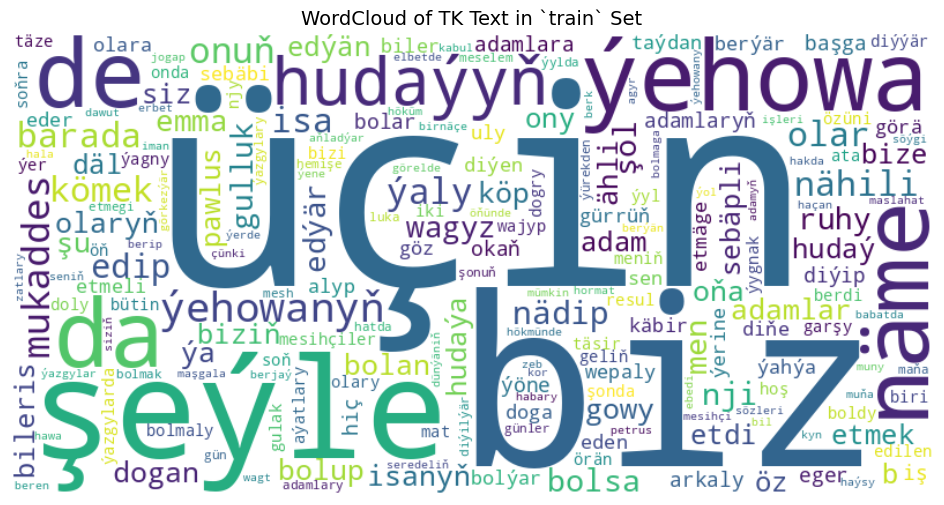

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Combine all text from your dataset ("tk" or "ru")
def generate_wordcloud(dataset_split, lang="tk"):
    # Choose 'tk' for Turkmen, 'ru' for Russian
    all_text = " ".join([example["translation"][lang] for example in dataset[dataset_split]])

    # Optional: extend stopwords (especially if using 'ru')
    custom_stopwords = set(STOPWORDS)
    if lang == "ru":
        custom_stopwords.update([
            "это", "как", "все", "его", "она", "что", "который", "тоже", "они", "был", "для", "это"
        ])
    elif lang == "tk":
        custom_stopwords.update([
            "bu", "ol", "hem", "diýdi", "bir", "iň", "bar", "bilen", "ýok", "hemme"
        ])

    # Generate WordCloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="white",
        stopwords=custom_stopwords,
        collocations=False
    ).generate(all_text.lower())

    # Display
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud of {lang.upper()} Text in `{dataset_split}` Set", fontsize=14)
    plt.show()

# Example usage
generate_wordcloud("train", lang="tk")  # or lang="ru"


Generating dev split: 0 examples [00:00, ? examples/s]

Generating devtest split: 0 examples [00:00, ? examples/s]

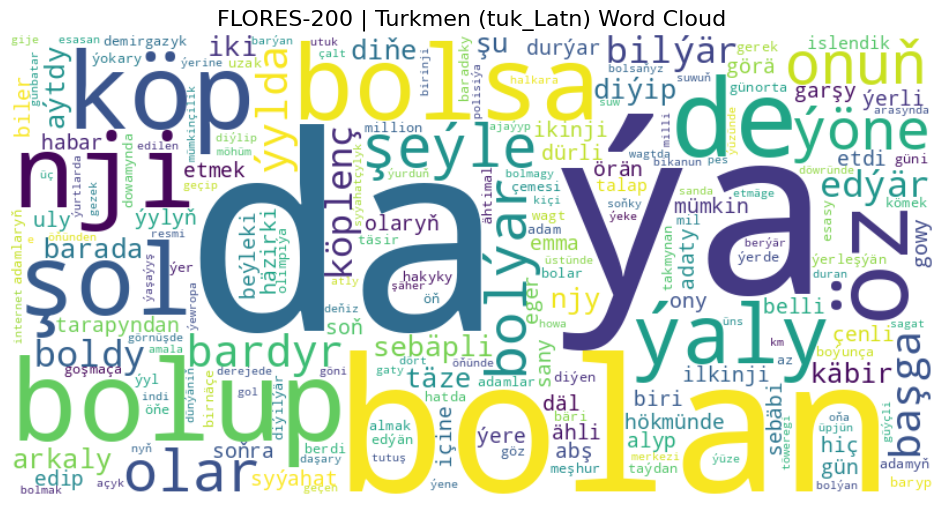

In [ ]:
# !pip install datasets wordcloud matplotlib

from datasets import load_dataset
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# 1️⃣ Load FLORES‑200 Turkmen split (uses custom loader, requires trust_remote_code)
ds = load_dataset(
    "Muennighoff/flores200",
    "tuk_Latn",
    split="dev",
    trust_remote_code=True
)
turk_texts = [ex["sentence"] for ex in ds]

# 2️⃣ Define Turkmen stopwords
turk_stops = set(STOPWORDS) | {
    "bu", "ol", "hem", "bir", "iň", "bilen", "bar", "hemme", "diýdi", "ýok", "üçin"
}

# 3️⃣ Generate a WordCloud
wc = WordCloud(
    width=800,
    height=400,
    background_color="white",
    stopwords=turk_stops,
    collocations=False
).generate(" ".join(turk_texts).lower())

# 4️⃣ Plot the WordCloud
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("FLORES‑200 | Turkmen (tuk_Latn) Word Cloud", fontsize=16)
plt.show()


In [ ]:
from datasets import load_dataset

ds_dev = load_dataset(
    "Muennighoff/flores200",
    "tuk_Latn",
    split="dev",
    trust_remote_code=True
)
ds_devtest = load_dataset(
    "Muennighoff/flores200",
    "tuk_Latn",
    split="devtest",
    trust_remote_code=True
)

print("Turkmen (tuk_Latn) split sizes:")
print(f" • dev      : {len(ds_dev)} sentences")
print(f" • devtest  : {len(ds_devtest)} sentences")
print(f" • TOTAL    : {len(ds_dev) + len(ds_devtest)} sentences")


Turkmen (tuk_Latn) split sizes:
 • dev      : 997 sentences
 • devtest  : 1012 sentences
 • TOTAL    : 2009 sentences


In [ ]:
ds_dev[8]


{'id': 9,
 'URL': 'https://en.wikinews.org/wiki/Thousands_march_in_London_calling_for_David_Cameron%27s_resignation_over_tax_affairs',
 'domain': 'wikinews',
 'topic': 'politics',
 'has_image': 0,
 'has_hyperlink': 0,
 'sentence': 'Sagat 11:00-yň göni yz ýanyndan protestçiler Waýtholda demirgazyk tarapa barýan ulaglaryň gatnawyny petiklediler.'}

In [ ]:
# ==== Before/After comparison for Bitext (rus–tuk) and STS17 (ru) ====
import os, numpy as np, torch, pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, PreTrainedModel
from datasets import load_dataset
from scipy.stats import pearsonr

# ---- Paths / names (adjust if needed) ----
MODEL_NAME = "facebook/nllb-200-distilled-600M"
FT_MODEL_PATH = "./final-nllb-turkmen-russian-lora"   # your fine-tuned model dir
TEST_SRC = "test.src"  # rus source (one line per sentence)
TEST_TRG = "test.trg"  # tuk target (aligned, one line per sentence)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---- Helpers ----
def mean_pool(last_hidden_state, attention_mask):
    m = attention_mask.unsqueeze(-1).float()
    s = torch.sum(last_hidden_state * m, dim=1)
    c = torch.clamp(m.sum(dim=1), min=1e-9)
    return s / c

def cosine_pairwise(a, b):
    a = a / np.linalg.norm(a, axis=1, keepdims=True)
    b = b / np.linalg.norm(b, axis=1, keepdims=True)
    return a @ b.T  # (N x N)

def compute_retrieval_metrics(src_emb, tgt_emb):
    sim = cosine_pairwise(src_emb, tgt_emb)
    N = sim.shape[0]
    top1 = sim.argmax(axis=1)
    p1 = float((top1 == np.arange(N)).sum()) / float(N)
    # MRR via rank of gold
    gold_scores = sim[np.arange(N), np.arange(N)]
    better = (sim > gold_scores[:, None]).sum(axis=1)
    mrr = (1.0 / (better + 1)).mean()
    return p1, mrr

def extract_embeddings(model: PreTrainedModel, tokenizer, texts, src_lang_code, bs=32, max_length=128):
    tokenizer.src_lang = src_lang_code
    enc = model.get_encoder()
    embs = []
    for i in range(0, len(texts), bs):
        batch = tokenizer(
            texts[i:i+bs], padding=True, truncation=True,
            max_length=max_length, return_tensors="pt"
        ).to(device)
        with torch.no_grad():
            out = enc(**batch).last_hidden_state
        pooled = mean_pool(out, batch["attention_mask"]).cpu().numpy()
        embs.append(pooled)
    return np.vstack(embs)

def sts17_pearson(model, base_tokenizer, bs=32, max_length=128):
    """Compute Pearson r on ai-forever/ru-stsbenchmark-sts (test split) using rus_Cyrl encoder on both sides."""
    ds = load_dataset("ai-forever/ru-stsbenchmark-sts", split="test")
    s1, s2, scores = ds["sentence1"], ds["sentence2"], np.array(ds["score"], dtype=np.float64)

    tok = AutoTokenizer.from_pretrained(base_tokenizer.name_or_path, src_lang="rus_Cyrl")
    e1 = extract_embeddings(model, tok, s1, "rus_Cyrl", bs=bs, max_length=max_length)
    e2 = extract_embeddings(model, tok, s2, "rus_Cyrl", bs=bs, max_length=max_length)

    # cosine similarity per pair
    sim = np.sum(e1 * e2, axis=1) / (np.linalg.norm(e1, axis=1) * np.linalg.norm(e2, axis=1))
    r, _ = pearsonr(sim, scores)
    return float(r)

def bitext_metrics(model, base_tokenizer):
    """Compute P@1 and MRR on aligned rus–tuk test pairs (rus_Cyrl -> tuk_Latn)."""
    with open(TEST_SRC, encoding="utf-8") as fs, open(TEST_TRG, encoding="utf-8") as ft:
        S = [ln.strip() for ln in fs if ln.strip()]
        T = [ln.strip() for ln in ft if ln.strip()]
    assert len(S) == len(T) and len(S) > 0, "Misaligned or empty bitext files."

    tok_ru = AutoTokenizer.from_pretrained(base_tokenizer.name_or_path, src_lang="rus_Cyrl")
    tok_tk = AutoTokenizer.from_pretrained(base_tokenizer.name_or_path, src_lang="tuk_Latn")

    src_emb = extract_embeddings(model, tok_ru, S, "rus_Cyrl")
    tgt_emb = extract_embeddings(model, tok_tk, T, "tuk_Latn")
    p1, mrr = compute_retrieval_metrics(src_emb, tgt_emb)
    return float(p1), float(mrr)

def evaluate_model(tag, model_path_or_name):
    print(f"\n== Loading {tag}: {model_path_or_name}")
    model = AutoModelForSeq2SeqLM.from_pretrained(model_path_or_name).to(device).eval()
    base_tok = AutoTokenizer.from_pretrained(MODEL_NAME)  # tokenizer source (NLLB codes)
    p1, mrr = bitext_metrics(model, base_tok)
    r = sts17_pearson(model, base_tok)
    return {"Model": tag, "Bitext P@1": p1, "Bitext MRR": mrr, "STS17 (ru) Pearson r": r}

# ---- Run both models ----
rows = []
rows.append(evaluate_model("Baseline (NLLB-200-600M)", MODEL_NAME))
rows.append(evaluate_model("Fine-tuned (LoRA)", FT_MODEL_PATH))

# ---- Show results ----
df = pd.DataFrame(rows)
print("\n=== Before/After Comparison ===")
print(df.to_string(index=False))

# (Optional) save
df.to_csv("before_after_bitext_sts17.csv", index=False)
print("\nSaved: before_after_bitext_sts17.csv")


In [ ]:
# ===========================
# LoRA fine-tuning NLLB encoder for STS17 (ru)
# ===========================
import os, math, random, numpy as np
from dataclasses import dataclass
from typing import List, Dict, Tuple
import torch
from torch import nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, get_cosine_schedule_with_warmup
from datasets import load_dataset
from scipy.stats import pearsonr, spearmanr
from peft import LoraConfig, TaskType, get_peft_model

# ---------------------------
# Config
# ---------------------------
MODEL_NAME = "facebook/nllb-200-distilled-600M"
OUTPUT_DIR = "./nllb_lora_sts_ru"
MAX_LEN = 128
BATCH_SIZE = 32
EPOCHS = 3
LR = 2e-4
WEIGHT_DECAY = 0.0
WARMUP_RATIO = 0.1
SEED = 42
LANG_CODE = "rus_Cyrl"   # STS17 Russian
GRAD_CLIP_NORM = 1.0
USE_FP16 = torch.cuda.is_available()

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------------------------
# Data
# ---------------------------
print("Loading dataset: ai-forever/ru-stsbenchmark-sts …")
ds = load_dataset("ai-forever/ru-stsbenchmark-sts")
# splits: train (5224), validation (1336), test (1264)

def normalize_target(scores: List[float]) -> np.ndarray:
    # Map scores in [0,5] -> [-1,1] to match cosine range
    s = np.asarray(scores, dtype=np.float32)
    return (s / 5.0) * 2.0 - 1.0

@dataclass
class STSBatch:
    input_ids_1: torch.Tensor
    attention_mask_1: torch.Tensor
    input_ids_2: torch.Tensor
    attention_mask_2: torch.Tensor
    targets: torch.Tensor

class STSDataset(torch.utils.data.Dataset):
    def __init__(self, texts1, texts2, targets, tokenizer, max_len=128, src_lang="rus_Cyrl"):
        self.s1 = texts1
        self.s2 = texts2
        self.y = normalize_target(targets)
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.src_lang = src_lang

    def __len__(self):
        return len(self.s1)

    def __getitem__(self, idx):
        return self.s1[idx], self.s2[idx], self.y[idx]

    def collate(self, batch) -> STSBatch:
        t1, t2, y = zip(*batch)
        self.tokenizer.src_lang = self.src_lang
        enc1 = self.tokenizer(
            list(t1), padding=True, truncation=True, max_length=self.max_len, return_tensors="pt"
        )
        enc2 = self.tokenizer(
            list(t2), padding=True, truncation=True, max_length=self.max_len, return_tensors="pt"
        )
        return STSBatch(
            input_ids_1=enc1["input_ids"],
            attention_mask_1=enc1["attention_mask"],
            input_ids_2=enc2["input_ids"],
            attention_mask_2=enc2["attention_mask"],
            targets=torch.tensor(y, dtype=torch.float32),
        )

# ---------------------------
# Model + LoRA (encoder only)
# ---------------------------
print("Loading base model & tokenizer …")
base_model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, src_lang=LANG_CODE)

# Freeze everything first
for p in base_model.parameters():
    p.requires_grad = False

# Inject LoRA into attention projections (encoder & decoder share naming, but we only use encoder forward)
lora_cfg = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM,
)
model = get_peft_model(base_model, lora_cfg).to(device)
print(model.print_trainable_parameters())

# We'll only use the encoder to produce sentence embeddings
encoder = model.get_encoder()

# ---------------------------
# Sentence embedding (mean pool)
# ---------------------------
def mean_pool(last_hidden_state: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
    mask = attention_mask.unsqueeze(-1).type_as(last_hidden_state)
    summed = torch.sum(last_hidden_state * mask, dim=1)
    counts = torch.clamp(mask.sum(dim=1), min=1e-9)
    return summed / counts

def encode_texts(input_ids, attention_mask) -> torch.Tensor:
    out = encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
    emb = mean_pool(out.last_hidden_state, attention_mask)
    # L2-normalize for cosine
    emb = emb / (emb.norm(p=2, dim=1, keepdim=True) + 1e-9)
    return emb

# ---------------------------
# Dataloaders
# ---------------------------
train_set = STSDataset(ds["train"]["sentence1"], ds["train"]["sentence2"], ds["train"]["score"], tokenizer, MAX_LEN, LANG_CODE)
dev_set   = STSDataset(ds["validation"]["sentence1"], ds["validation"]["sentence2"], ds["validation"]["score"], tokenizer, MAX_LEN, LANG_CODE)
test_set  = STSDataset(ds["test"]["sentence1"], ds["test"]["sentence2"], ds["test"]["score"], tokenizer, MAX_LEN, LANG_CODE)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_set.collate, drop_last=False)
dev_loader   = DataLoader(dev_set,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=dev_set.collate, drop_last=False)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=test_set.collate, drop_last=False)

# ---------------------------
# Optimizer & Scheduler
# ---------------------------
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(trainable_params, lr=LR, weight_decay=WEIGHT_DECAY)
num_training_steps = EPOCHS * math.ceil(len(train_loader))
num_warmup = int(WARMUP_RATIO * num_training_steps)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup, num_training_steps)

scaler = torch.cuda.amp.GradScaler(enabled=USE_FP16)
loss_fn = nn.MSELoss()

# ---------------------------
# Eval helpers
# ---------------------------
@torch.no_grad()
def evaluate(loader, name="dev") -> Tuple[float, float, float]:
    model.eval()
    all_pred_cos = []
    all_gold_cos = []
    for batch in loader:
        ids1 = batch.input_ids_1.to(device); m1 = batch.attention_mask_1.to(device)
        ids2 = batch.input_ids_2.to(device); m2 = batch.attention_mask_2.to(device)
        y    = batch.targets.to(device)  # in [-1,1]

        e1 = encode_texts(ids1, m1)
        e2 = encode_texts(ids2, m2)
        cos = torch.sum(e1 * e2, dim=1)  # cosine similarity

        all_pred_cos.append(cos.detach().cpu().numpy())
        all_gold_cos.append(y.detach().cpu().numpy())

    pred = np.concatenate(all_pred_cos)
    gold = np.concatenate(all_gold_cos)
    # Map gold back to 0..5 for reporting correlations with raw STS scores
    gold_raw = (gold + 1.0) * 2.5
    pred_raw = (pred + 1.0) * 2.5

    r = pearsonr(pred_raw, gold_raw).statistic
    s = spearmanr(pred_raw, gold_raw).statistic
    mse = float(np.mean((pred - gold) ** 2))
    print(f"[{name}] Pearson: {r:.4f} | Spearman: {s:.4f} | MSE(cos): {mse:.5f}")
    return r, s, mse

# ---------------------------
# Train loop
# ---------------------------
best_dev = -1.0
global_step = 0
print("Starting training …")
for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0

    for batch in train_loader:
        ids1 = batch.input_ids_1.to(device); m1 = batch.attention_mask_1.to(device)
        ids2 = batch.input_ids_2.to(device); m2 = batch.attention_mask_2.to(device)
        y    = batch.targets.to(device)  # [-1,1]

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=USE_FP16):
            e1 = encode_texts(ids1, m1)
            e2 = encode_texts(ids2, m2)
            cos = torch.sum(e1 * e2, dim=1)  # [-1,1]
            loss = loss_fn(cos, y)

        scaler.scale(loss).backward()
        # Gradient clipping (only LoRA params)
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(trainable_params, GRAD_CLIP_NORM)

        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        running_loss += loss.item()
        global_step += 1

        if global_step % 100 == 0:
            print(f"Step {global_step}: loss = {running_loss / 100:.5f}")
            running_loss = 0.0

    print(f"Epoch {epoch} finished. Evaluating …")
    pearson_dev, spearman_dev, _ = evaluate(dev_loader, name="dev")

    # Save best adapter by dev Pearson
    if pearson_dev > best_dev:
        best_dev = pearson_dev
        print(f"New best dev Pearson {best_dev:.4f}. Saving adapter -> {OUTPUT_DIR}")
        model.save_pretrained(OUTPUT_DIR)

# ---------------------------
# Final evaluation on test
# ---------------------------
print("\nLoading best adapter and evaluating on TEST …")
best_model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)
best_model = get_peft_model(best_model, lora_cfg)
best_model.load_adapter(OUTPUT_DIR, adapter_name="default")
best_model.set_adapter("default")
best_model = best_model.to(device)
encoder = best_model.get_encoder()  # refresh handle

evaluate(test_loader, name="test")

print("\nDone. Adapter saved at:", OUTPUT_DIR)
print("To use later:\n"
      "base = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)\n"
      "base = get_peft_model(base, lora_cfg)\n"
      "base.load_adapter(OUTPUT_DIR, adapter_name='sts_ru'); base.set_adapter('sts_ru')\n"
      "encoder = base.get_encoder()  # then mean-pool for embeddings")


Device: cuda
Loading dataset: ai-forever/ru-stsbenchmark-sts …


README.md:   0%|          | 0.00/349 [00:00<?, ?B/s]

sts_rumteb_train.json: 0.00B [00:00, ?B/s]

sts_rumteb_test.json: 0.00B [00:00, ?B/s]

sts_rumteb_dev.json: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/5224 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1264 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1336 [00:00<?, ? examples/s]

Loading base model & tokenizer …
trainable params: 2,359,296 || all params: 617,433,088 || trainable%: 0.3821
None
Starting training …


/tmp/ipython-input-918573973.py:156: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_FP16)
/tmp/ipython-input-918573973.py:208: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_FP16):


Step 100: loss = 0.73243
Epoch 1 finished. Evaluating …
[dev] Pearson: 0.4831 | Spearman: 0.4862 | MSE(cos): 0.44631
New best dev Pearson 0.4831. Saving adapter -> ./nllb_lora_sts_ru
Step 200: loss = 0.14042
Step 300: loss = 0.36599
Epoch 2 finished. Evaluating …
[dev] Pearson: 0.4582 | Spearman: 0.4735 | MSE(cos): 0.39654
Step 400: loss = 0.25050
Epoch 3 finished. Evaluating …
[dev] Pearson: 0.4631 | Spearman: 0.4801 | MSE(cos): 0.39316

Loading best adapter and evaluating on TEST …
[test] Pearson: 0.4665 | Spearman: 0.4648 | MSE(cos): 0.42557

Done. Adapter saved at: ./nllb_lora_sts_ru
To use later:
base = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)
base = get_peft_model(base, lora_cfg)
base.load_adapter(OUTPUT_DIR, adapter_name='sts_ru'); base.set_adapter('sts_ru')
encoder = base.get_encoder()  # then mean-pool for embeddings


In [ ]:
# ===============================================================
# NLLB-200: Train LoRA STS (InfoNCE) and Compare (Baseline vs Bitext vs STS)
# ===============================================================
import os, math, random, numpy as np, pandas as pd
from dataclasses import dataclass
from typing import List, Tuple
import torch
from torch import nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, get_cosine_schedule_with_warmup, PreTrainedModel
from datasets import load_dataset
from scipy.stats import pearsonr, spearmanr
from peft import LoraConfig, TaskType, get_peft_model

# ---------------------------
# Config (EDIT HERE if needed)
# ---------------------------
MODEL_NAME = "facebook/nllb-200-distilled-600M"
BITEXT_ADAPTER_PATH = "./final-nllb-turkmen-russian-lora"   # your already trained MT LoRA
STS_ADAPTER_OUT = "./nllb_lora_sts_ru_infonce"              # this script will write here

LANG_RU = "rus_Cyrl"
LANG_TK = "tuk_Latn"

MAX_LEN = 128
BATCH_SIZE = 32
EPOCHS = 3
LR = 1e-4
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.1
SEED = 42
GRAD_CLIP_NORM = 1.0
USE_FP16 = torch.cuda.is_available()
TEMPERATURE = 0.05
PATIENCE = 2  # early stopping on dev Pearson

# Bitext test files (keep same N/order)
TEST_SRC = "test.src"  # Russian lines
TEST_TRG = "test.trg"  # Turkmen lines

os.makedirs(STS_ADAPTER_OUT, exist_ok=True)

# ---------------------------
# Reproducibility
# ---------------------------
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------------------------
# Data: STS17 (ru)
# ---------------------------
print("Loading dataset: ai-forever/ru-stsbenchmark-sts …")
ds = load_dataset("ai-forever/ru-stsbenchmark-sts")
# splits: train (5224), validation (1336), test (1264) — order is fixed

@dataclass
class STSBatch:
    input_ids_1: torch.Tensor
    attention_mask_1: torch.Tensor
    input_ids_2: torch.Tensor
    attention_mask_2: torch.Tensor

class STSDataset(torch.utils.data.Dataset):
    def __init__(self, texts1, texts2, tokenizer, max_len=128, src_lang="rus_Cyrl"):
        self.s1 = texts1
        self.s2 = texts2
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.src_lang = src_lang

    def __len__(self):
        return len(self.s1)

    def __getitem__(self, idx):
        return self.s1[idx], self.s2[idx]

    def collate(self, batch) -> STSBatch:
        t1, t2 = zip(*batch)
        self.tokenizer.src_lang = self.src_lang
        enc1 = self.tokenizer(list(t1), padding=True, truncation=True, max_length=self.max_len, return_tensors="pt")
        enc2 = self.tokenizer(list(t2), padding=True, truncation=True, max_length=self.max_len, return_tensors="pt")
        return STSBatch(
            input_ids_1=enc1["input_ids"],
            attention_mask_1=enc1["attention_mask"],
            input_ids_2=enc2["input_ids"],
            attention_mask_2=enc2["attention_mask"],
        )

# ---------------------------
# Model + LoRA (encoder only, InfoNCE)
# ---------------------------
print("Loading base model & tokenizer …")
base_model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, src_lang=LANG_RU)

# Freeze everything first
for p in base_model.parameters():
    p.requires_grad = False

# Inject LoRA into attention projections (encoder usage)
target_modules = ["q_proj", "v_proj"]  # You can also try ["q_proj","k_proj","v_proj","o_proj"]
lora_cfg = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=target_modules,
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM,
)
model = get_peft_model(base_model, lora_cfg).to(device)
print(model.print_trainable_parameters())
encoder = model.get_encoder()

# ---------------------------
# Sentence embeddings (mean pool + L2 norm)
# ---------------------------
def mean_pool(last_hidden_state: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
    mask = attention_mask.unsqueeze(-1).type_as(last_hidden_state)
    summed = torch.sum(last_hidden_state * mask, dim=1)
    counts = torch.clamp(mask.sum(dim=1), min=1e-9)
    emb = summed / counts
    emb = emb / (emb.norm(p=2, dim=1, keepdim=True) + 1e-9)
    return emb

def encode_texts(input_ids, attention_mask) -> torch.Tensor:
    out = encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
    return mean_pool(out.last_hidden_state, attention_mask)

# ---------------------------
# Dataloaders
# ---------------------------
train_set = STSDataset(ds["train"]["sentence1"], ds["train"]["sentence2"], tokenizer, MAX_LEN, LANG_RU)
dev_set   = STSDataset(ds["validation"]["sentence1"], ds["validation"]["sentence2"], tokenizer, MAX_LEN, LANG_RU)
test_set  = STSDataset(ds["test"]["sentence1"], ds["test"]["sentence2"], tokenizer, MAX_LEN, LANG_RU)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  collate_fn=train_set.collate, drop_last=False)
dev_loader   = DataLoader(dev_set,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=dev_set.collate,   drop_last=False)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=test_set.collate,  drop_last=False)

# ---------------------------
# Optimizer & Scheduler
# ---------------------------
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(trainable_params, lr=LR, weight_decay=WEIGHT_DECAY)
num_training_steps = EPOCHS * math.ceil(len(train_loader))
num_warmup = int(WARMUP_RATIO * num_training_steps)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup, num_training_steps)

scaler = torch.amp.GradScaler('cuda', enabled=USE_FP16)
ce_loss = nn.CrossEntropyLoss()

def infonce_loss(e1, e2, temperature=TEMPERATURE):
    # symmetric InfoNCE with in-batch negatives
    logits = (e1 @ e2.T) / temperature
    labels = torch.arange(logits.size(0), device=logits.device)
    return (ce_loss(logits, labels) + ce_loss(logits.T, labels)) / 2.0

# ---------------------------
# Eval: Pearson/Spearman on STS (fixed order)
# ---------------------------
@torch.no_grad()
def eval_sts(loader, gold_scores: np.ndarray, name="dev") -> Tuple[float, float]:
    model.eval()
    all_cos = []
    for batch in loader:
        ids1 = batch.input_ids_1.to(device); m1 = batch.attention_mask_1.to(device)
        ids2 = batch.input_ids_2.to(device); m2 = batch.attention_mask_2.to(device)
        e1 = encode_texts(ids1, m1)
        e2 = encode_texts(ids2, m2)
        cos = torch.sum(e1 * e2, dim=1).detach().cpu().numpy()
        all_cos.append(cos)
    pred = np.concatenate(all_cos)
    r  = pearsonr(pred, gold_scores).statistic
    ro = spearmanr(pred, gold_scores).statistic
    print(f"[{name}] Pearson: {r:.4f} | Spearman: {ro:.4f}")
    return float(r), float(ro)

# ---------------------------
# Train (with early stopping on dev Pearson)
# ---------------------------
best_dev = -1.0
bad_epochs = 0
global_step = 0
print("Starting training (InfoNCE)…")

dev_gold = np.array(ds["validation"]["score"], dtype=np.float64)
test_gold = np.array(ds["test"]["score"], dtype=np.float64)

for epoch in range(1, EPOCHS + 1):
    model.train()
    running = 0.0
    for batch in train_loader:
        ids1 = batch.input_ids_1.to(device); m1 = batch.attention_mask_1.to(device)
        ids2 = batch.input_ids_2.to(device); m2 = batch.attention_mask_2.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda', enabled=USE_FP16):
            e1 = encode_texts(ids1, m1)
            e2 = encode_texts(ids2, m2)
            loss = infonce_loss(e1, e2)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(trainable_params, GRAD_CLIP_NORM)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        running += loss.item()
        global_step += 1
        if global_step % 100 == 0:
            print(f"Step {global_step}: loss={running/100:.5f}")
            running = 0.0

    print(f"Epoch {epoch} finished. Evaluating on dev …")
    dev_pearson, dev_spearman = eval_sts(dev_loader, dev_gold, name="dev")
    if dev_pearson > best_dev:
        best_dev = dev_pearson
        bad_epochs = 0
        print(f"New best dev Pearson {best_dev:.4f}. Saving adapter -> {STS_ADAPTER_OUT}")
        model.save_pretrained(STS_ADAPTER_OUT)
    else:
        bad_epochs += 1
        if bad_epochs >= PATIENCE:
            print("Early stopping triggered.")
            break

# ---------------------------
# Load best STS adapter for final evals
# ---------------------------
print("\nLoading best STS adapter for final evaluation…")
best_model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)
best_model = get_peft_model(best_model, lora_cfg)
best_model.load_adapter(STS_ADAPTER_OUT, adapter_name="sts")
best_model.set_adapter("sts")
best_model = best_model.to(device)
best_encoder = best_model.get_encoder()

def extract_embeddings(model: PreTrainedModel, base_tokenizer, texts, src_lang_code, bs=32, max_len=128):
    base_tokenizer.src_lang = src_lang_code
    enc = model.get_encoder()
    embs = []
    for i in range(0, len(texts), bs):
        batch = base_tokenizer(texts[i:i+bs], padding=True, truncation=True, max_length=max_len, return_tensors="pt").to(device)
        with torch.no_grad():
            out = enc(**batch).last_hidden_state
        # mean pool + L2
        mask = batch["attention_mask"]
        m = mask.unsqueeze(-1).type_as(out)
        pooled = (out * m).sum(dim=1) / torch.clamp(m.sum(dim=1), min=1e-9)
        pooled = pooled / (pooled.norm(p=2, dim=1, keepdim=True) + 1e-9)
        embs.append(pooled.cpu().numpy())
    return np.vstack(embs)

def cosine_pairwise(a, b):
    a = a / np.linalg.norm(a, axis=1, keepdims=True)
    b = b / np.linalg.norm(b, axis=1, keepdims=True)
    return a @ b.T

def bitext_metrics_from_files(model: PreTrainedModel, base_tokenizer) -> Tuple[float, float]:
    # Preserve EXACT N and order from your files
    with open(TEST_SRC, encoding="utf-8") as fs, open(TEST_TRG, encoding="utf-8") as ft:
        S = [ln.strip() for ln in fs if ln.strip()]
        T = [ln.strip() for ln in ft if ln.strip()]
    assert len(S) == len(T) and len(S) > 0, "Misaligned or empty bitext files."
    src_emb = extract_embeddings(model, base_tokenizer, S, LANG_RU, bs=32, max_len=MAX_LEN)
    tgt_emb = extract_embeddings(model, base_tokenizer, T, LANG_TK, bs=32, max_len=MAX_LEN)
    sim = cosine_pairwise(src_emb, tgt_emb)
    N = sim.shape[0]
    top1 = sim.argmax(axis=1)
    p1 = float((top1 == np.arange(N)).sum()) / float(N)
    gold = sim[np.arange(N), np.arange(N)]
    better = (sim > gold[:, None]).sum(axis=1)
    mrr = float((1.0 / (better + 1)).mean())
    return p1, mrr

@torch.no_grad()
def sts17_scores(model: PreTrainedModel, base_tokenizer) -> Tuple[float, float]:
    s1 = ds["test"]["sentence1"]
    s2 = ds["test"]["sentence2"]
    gold = np.array(ds["test"]["score"], dtype=np.float64)
    e1 = extract_embeddings(model, base_tokenizer, s1, LANG_RU, bs=32, max_len=MAX_LEN)
    e2 = extract_embeddings(model, base_tokenizer, s2, LANG_RU, bs=32, max_len=MAX_LEN)
    pred = (e1 * e2).sum(axis=1)
    r = float(pearsonr(pred, gold).statistic)
    ro = float(spearmanr(pred, gold).statistic)
    return r, ro

# ---------------------------
# Build comparisons: Baseline, Bitext LoRA, STS LoRA
# ---------------------------
def eval_variant(tag: str, load_fn):
    print(f"\n== Evaluating variant: {tag}")
    model = load_fn().eval().to(device)
    base_tok = AutoTokenizer.from_pretrained(MODEL_NAME, src_lang=LANG_RU)
    r, ro = sts17_scores(model, base_tok)
    p1, mrr = bitext_metrics_from_files(model, base_tok)
    print(f"[{tag}] STS17 ru: r={r:.4f}, ρ={ro:.4f} | Bitext: P@1={p1:.4f}, MRR={mrr:.4f}")
    return {"Variant": tag, "STS17 Pearson r": r, "STS17 Spearman ρ": ro, "Bitext P@1": p1, "Bitext MRR": mrr}

def load_baseline():
    return AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

def load_bitext():
    p = os.path.abspath(BITEXT_ADAPTER_PATH)
    assert os.path.isdir(p), f"Bitext adapter folder not found: {p}\nCheck your working dir or set BITEXT_ADAPTER_PATH correctly."

    # Try: adapter-only weights on top of base
    try:
        base = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME, local_files_only=False)
        base = get_peft_model(base, lora_cfg)
        base.load_adapter(p, adapter_name="bitext")
        base.set_adapter("bitext")
        return base
    except Exception as e1:
        print(f"[load_bitext] Adapter-only load failed: {e1}\nTrying to load as a full PEFT model dir…")
        # Fallback: directory contains a full PeftModel (trainer.save_model)
        try:
            model = PeftModel.from_pretrained(
                AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME, local_files_only=False),
                p, is_trainable=False
            )
            return model
        except Exception as e2:
            print(f"[load_bitext] Full PEFT load also failed: {e2}")
            raise

def load_sts():
    m = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)
    m = get_peft_model(m, lora_cfg)
    m.load_adapter(STS_ADAPTER_OUT, adapter_name="sts")
    m.set_adapter("sts")
    return m

rows = []
rows.append(eval_variant("Baseline NLLB", load_baseline))
rows.append(eval_variant("NLLB + LoRA (bitext)", load_bitext))
rows.append(eval_variant("NLLB + LoRA (sts, InfoNCE)", load_sts))

df = pd.DataFrame(rows)
print("\n=== Consolidated Comparison (same N/order) ===")
print(df.to_string(index=False))
df.to_csv("nllb_compare_bitext_sts17.csv", index=False)
print("\nSaved: nllb_compare_bitext_sts17.csv")



Device: cuda
Loading dataset: ai-forever/ru-stsbenchmark-sts …
Loading base model & tokenizer …
trainable params: 2,359,296 || all params: 617,433,088 || trainable%: 0.3821
None
Starting training (InfoNCE)…
Step 100: loss=0.62421
Epoch 1 finished. Evaluating on dev …
[dev] Pearson: 0.7552 | Spearman: 0.7531
New best dev Pearson 0.7552. Saving adapter -> ./nllb_lora_sts_ru_infonce
Step 200: loss=0.19994
Step 300: loss=0.55518
Epoch 2 finished. Evaluating on dev …
[dev] Pearson: 0.7468 | Spearman: 0.7455
Step 400: loss=0.36380
Epoch 3 finished. Evaluating on dev …
[dev] Pearson: 0.7453 | Spearman: 0.7442
Early stopping triggered.

Loading best STS adapter for final evaluation…

== Evaluating variant: Baseline NLLB
[Baseline NLLB] STS17 ru: r=0.7004, ρ=0.6839 | Bitext: P@1=1.0000, MRR=1.0000

== Evaluating variant: NLLB + LoRA (bitext)
[NLLB + LoRA (bitext)] STS17 ru: r=0.6998, ρ=0.6833 | Bitext: P@1=1.0000, MRR=1.0000

== Evaluating variant: NLLB + LoRA (sts, InfoNCE)
[NLLB + LoRA (sts, 